In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import testcases
from importlib import reload
import class_flp
import utils
import time
import pickle
import datetime

In [70]:
reload(class_flp)
n_testcases = 10
list_N = [100*(i+1) for i in range(n_testcases)]
list_M = [int(2+0.8*i) for i in range(n_testcases)]
size_array = list(zip(list_N, list_M))
# size_array = list(zip(range(50, 251, 50), range(3, 6)))
d = 2
N_init_cond = 10
print(f'beta: {beta0}')

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10.0
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3


beta: 0.0021530046996068894


In [72]:
reload(class_flp)
# storage arrays
t_cbf = np.zeros((N_init_cond, len(size_array)))
t_sgf = np.zeros((N_init_cond, len(size_array)))
b_array = []

for k in range(N_init_cond):
    beta0 = np.random.uniform(0.001, 0.01*3**(k))
    b_array.append(beta0)
    print(f'Instance {k}\tbeta0:{beta0:.4e}')
    for i, (N,M) in enumerate(size_array):

        resLoc, Y0, res_means, split_pct, rho = testcases.generate_testcase(
            N, M, d, unif_split=True, cluster_cov=10, seed=k, sq_size=20, normalizer=False)
        # allocation cost
        np.random.seed(k)
        alloc_cost = np.random.uniform(100,200,(N,M))
        mean_alloc_cost = np.mean(alloc_cost)
        C = np.random.uniform(0.3,1,len(split_pct))
        # C = np.ones(shape=split_pct.shape)
        C = (C/np.sum(C) + 0.02) * mean_alloc_cost
        B = np.random.uniform(C.min()*0.2, C.min()*0.5, len(split_pct))

        # initialize FLP class
        flp = class_flp.FLP(N, M, d, resLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

        # initialize state
        Y0 = np.random.uniform(10,20,(flp.M, flp.d))
        P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
        P0 = P0/P0.sum(axis=1,keepdims=True)
        x0 = utils.YP2x(Y0, P0)

        print(f'\titer {i}\tsize: ({N,M})\tx0_shape: {x0.shape}')

        # CLF_CBF control computation
        t0 = time.time()
        u_p, u_y, F, Fdot = flp.control_dyn(x0, beta0, u_b, p1, p2, gamma, alpha_h, alpha_l)
        t1 = time.time()
        t_cbf[k,i] = t1-t0
        # print(f'\t\tCBF time: {t_cbf[k,i]:.3f}')

        # SGF optimization
        t2 = time.time()
        u, v = flp.calc_u1(x0, beta0, alpha, kappa)
        t3 = time.time()
        t_sgf[k,i] = t3-t2
        # print(f'\t\tSGF time: {t_sgf[k,i]:.3f}')


Instance 0	beta0:1.3294e-03
	iter 0	size: ((100, 2))	x0_shape: (204,)
	iter 1	size: ((200, 2))	x0_shape: (404,)
	iter 2	size: ((300, 3))	x0_shape: (906,)
	iter 3	size: ((400, 4))	x0_shape: (1608,)
	iter 4	size: ((500, 5))	x0_shape: (2510,)
	iter 5	size: ((600, 6))	x0_shape: (3612,)
	iter 6	size: ((700, 6))	x0_shape: (4212,)
	iter 7	size: ((800, 7))	x0_shape: (5614,)
	iter 8	size: ((900, 8))	x0_shape: (7216,)
	iter 9	size: ((1000, 9))	x0_shape: (9018,)
Instance 1	beta0:1.6700e-03
	iter 0	size: ((100, 2))	x0_shape: (204,)
	iter 1	size: ((200, 2))	x0_shape: (404,)
	iter 2	size: ((300, 3))	x0_shape: (906,)
	iter 3	size: ((400, 4))	x0_shape: (1608,)
	iter 4	size: ((500, 5))	x0_shape: (2510,)
	iter 5	size: ((600, 6))	x0_shape: (3612,)
	iter 6	size: ((700, 6))	x0_shape: (4212,)
	iter 7	size: ((800, 7))	x0_shape: (5614,)
	iter 8	size: ((900, 8))	x0_shape: (7216,)
	iter 9	size: ((1000, 9))	x0_shape: (9018,)
Instance 2	beta0:4.3290e-02
	iter 0	size: ((100, 2))	x0_shape: (204,)
	iter 1	size: ((20

In [73]:
# str(datetime.datetime.today()).split()
current_time = datetime.datetime.now()
yyyy = str(current_time.year)
mm = str(current_time.month)
dd = str(current_time.day)
hh = str(current_time.hour)
mt = str(current_time.minute)
sec = str(current_time.second)
current_datetime = yyyy + '_' + mm + '_' + dd + '_' + hh + '_' + mt + '_' + sec 

In [74]:
# save data
savedata = {'size_array':size_array, 'b_array':b_array, 't_cbf':t_cbf, 't_sgf':t_sgf}
filedir = 'Simulations_and_results/final_results/control_compare/Our_SGF_control_compare_'
filename = filedir + current_datetime + '.pkl'

with open(filename, 'wb') as file:
    pickle.dump(savedata, file)

In [3]:
filedir = 'Simulations_and_results/final_results/control_compare/Our_SGF_control_compare_'
filename = filedir+'2025_3_29_19_54_51.pkl'
with open(filename, 'rb') as file:
    loaddata = pickle.load(file)

t1_cbf = loaddata['t_cbf']
t1_sgf = loaddata['t_sgf']
size_array = loaddata['size_array']

# Compute average values
m_t_cbf = np.mean(t1_cbf, axis=0)
m_t_sgf = np.mean(t1_sgf, axis=0)

# compute rescaled time values
norm_m_t_cbf = m_t_cbf#/m_t_cbf
norm_m_t_sgf = m_t_sgf#/m_t_cbf


In [100]:
# plt.figure(figsize=(6,3))
# plt.plot(m_t_cbf)
# plt.show()
# plt.figure(figsize=(6,3))
# plt.plot(m_t_sgf)
# plt.show()

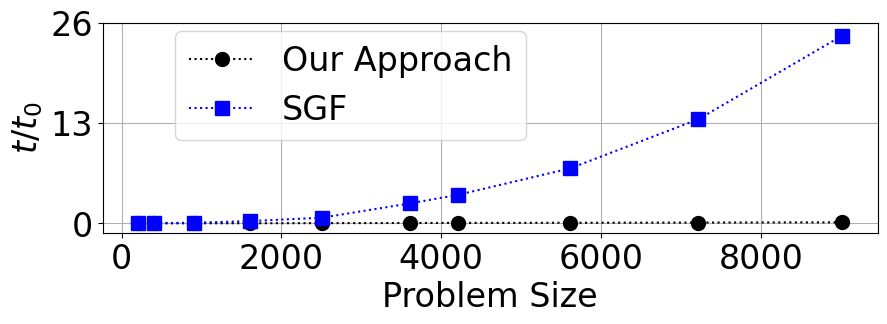

In [8]:
fontSize = 24
clr = {'our':'black', 'SGF':'blue', 'SLSQP':'violet'}
mk = {'our':'o', 'SGF':'s', 'SLSQP':'v'}
mks = {'our':10, 'SGF':10, 'SLSQP':10}
lb = {'our':'Our Approach', 'SGF':'SGF', 'SLSQP':'SLSQP'}


plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
xticks = [n*m+2*m for n, m in size_array]
plt.plot(xticks, norm_m_t_cbf, color=clr['our'], marker=mk['our'], markersize=mks['our'], label=lb['our'], linestyle='dotted')  # Plot F with blue circles
plt.plot(xticks, norm_m_t_sgf, color=clr['SGF'], marker=mk['SGF'], markersize=mks['SGF'], label=lb['SGF'], linestyle='dotted')  # Plot G with red circles

plt.ylabel(rf"$t/t_0$", fontsize=fontSize)
plt.xlabel(rf"Problem Size", fontsize=fontSize)
ymin_t, ymax_t = plt.ylim()
yticks = [int(y) for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
plt.yticks(yticks, fontsize=fontSize)
plt.xticks(fontsize=fontSize)
plt.legend(fontsize=fontSize, ncol=1, loc="center", bbox_to_anchor=(0.32, 0.7))
plt.grid(True)

# plt.subplot(1,2,2)
# xticks = [n*m+2*m for n, m in size_array]
# # plt.plot(xticks, norm_m_t_cbf, color=clr['our'], marker=mk['our'], markersize=mks['our'], label=lb['our'], linestyle='dotted')  # Plot F with blue circles
# plt.plot(xticks, norm_m_t_sgf, color=clr['SGF'], marker=mk['SGF'], markersize=mks['SGF'], label=lb['SGF'], linestyle='dotted')  # Plot G with red circles

# plt.ylabel(rf"$t/t_0$", fontsize=fontSize)
# plt.xlabel(rf"Problem Size", fontsize=fontSize)
# ymin_t, ymax_t = plt.ylim()
# yticks = [y for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
# plt.yticks(yticks, fontsize=fontSize)
# plt.xticks(fontsize=fontSize)
# plt.legend(fontsize=fontSize, ncol=1, loc="center", bbox_to_anchor=(0.32, 0.7))
# plt.grid(True)


plt.savefig(filename[:-3]+'pdf', format="pdf")
plt.show()

In [9]:
xticks

[204, 404, 906, 1608, 2510, 3612, 4212, 5614, 7216, 9018]

In [10]:
norm_m_t_cbf

array([0.01435566, 0.01328366, 0.01896467, 0.0272449 , 0.03876047,
       0.06001177, 0.0669889 , 0.08664677, 0.1122813 , 0.14502087])

In [11]:
norm_m_t_sgf

array([1.99964523e-02, 3.51958275e-02, 8.70716095e-02, 2.99766135e-01,
       7.48479581e-01, 2.60305734e+00, 3.70946124e+00, 7.13503768e+00,
       1.34980155e+01, 2.43373586e+01])